# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---

#### Create mapping dictionary from csv file

In [1]:
import csv

map_ids = []
with open('signnames.csv', 'r') as map_file:
    reader = csv.reader(map_file, delimiter=',')
    next(reader,None)
    for row in reader:
        map_ids.append(row[1])

---
## Step 0: Load The Data

The provided data is already devided into training, validation and test set. First the different data sets are loaded into workspace.

In [2]:
import pickle

training_file = "../traffic-signs-data/train.p"
validation_file = "../traffic-signs-data/valid.p"
testing_file = "../traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

---

## Step 1: Dataset Summary & Exploration

### Basic Summary of the Data Set

The data sets all consist of a dictionary with 4 key/value pairs:

* `features`: A 4D array containing all the RGB images (# of images, width, height, color channels).
* `labels`: A 1D array containing the class ids for each traffic sign. The provided file `signnames.csv` contains a mapping from the class ids to the label names of the included signs.
* `sizes`: A list of tuples containing the widths and heights of the original images.
* `coords`: A list of tuples containing the coordinates of bounding boxes around the signs in the original images.

In this project only `features` and `labels` are used. `sizes` and `coords` are not needed.

In [3]:
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [4]:
import numpy as np

n_train = len(X_train)
n_valid = len(X_valid)
n_test = len(X_test)
image_shape = X_test.shape[1:]
n_classes = np.max(y_test)+1

print('{:<30}{:^5}{:<10}'.format('Number of training examples', '=', n_train))
print('{:<30}{:^5}{:<10}'.format('Number of validation examples', '=', n_valid))
print('{:<30}{:^5}{:<10}'.format('Number of testing examples', '=', n_test))
print('{:<30}{:^5}{:<10}'.format('Image shape', '=', 
                                 str(image_shape[0])+'x'+str(image_shape[1])+'x'+str(image_shape[2])))
print('{:<30}{:^5}{:<10}'.format('Number of classes', '=', n_classes))

Number of training examples     =  34799     
Number of validation examples   =  4410      
Number of testing examples      =  12630     
Image shape                     =  32x32x3   
Number of classes               =  43        


### Include an exploratory visualization of the dataset

#### Plot example images of each class

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_all(X_data, y_data, n_rows=n_classes, n_cols=5):
    '''Function plots example images of all classes. n_rows specifies the number of classes shown, 
    n_cols the number of images per class.'''
    number_of_images = n_rows*n_cols
    figure, axis = plt.subplots(n_rows, n_cols+1, figsize=(5, 43))

    for i_row in range(n_rows):
        idx_spc = np.where(y_data==i_row)
        for i_col in range(n_cols):
            idx = np.random.randint(idx_spc[0][0],idx_spc[0][-1])
            image = X_data[idx,:,:,:]
            axis[i_row,i_col].axis('off')
            axis[i_row,i_col].imshow(image)
            if i_col==n_cols-1:
                axis[i_row,i_col+1].axis('off')
                axis[i_row,i_col+1].text(.5,.5,map_ids[i_row],ha='left')

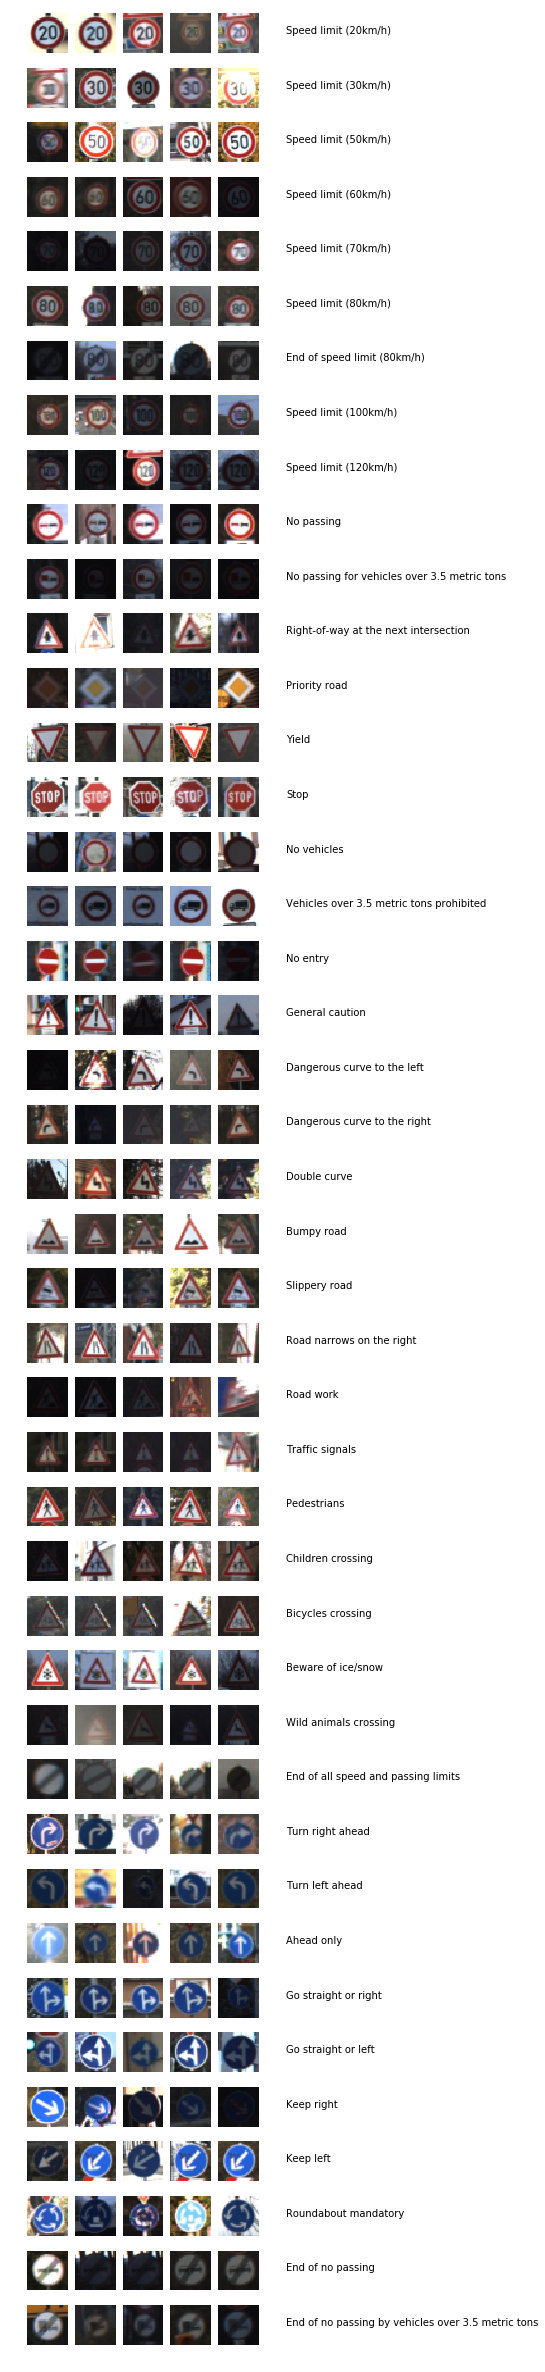

In [6]:
plot_all(X_train, y_train)

#### Plot dataset class distributions

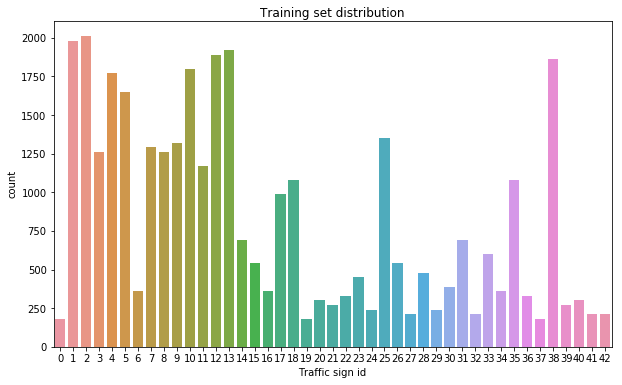

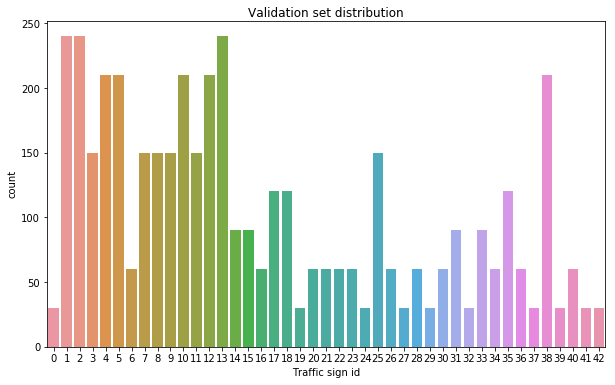

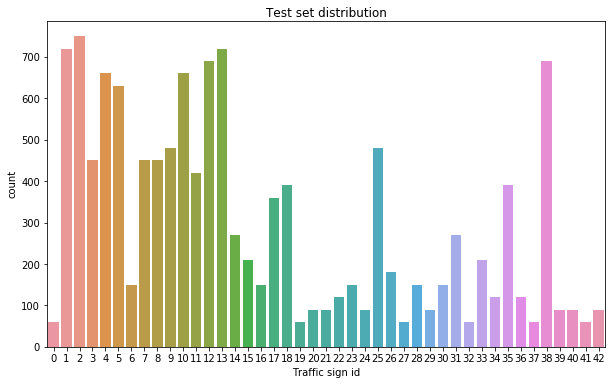

In [7]:
import seaborn as sns

fig = plt.figure(figsize=(10,6))
p = sns.countplot(y_train)
plt.title('Training set distribution')
plt.xlabel('Traffic sign id')
plt.show()

fig = plt.figure(figsize=(10,6))
sns.countplot(y_valid)
plt.title('Validation set distribution')
plt.xlabel('Traffic sign id')
plt.show()

fig = plt.figure(figsize=(10,6))
sns.countplot(y_test)
plt.title('Test set distribution')
plt.xlabel('Traffic sign id')
plt.show()

### Data augmentation

In order to balance the existing unbalanced training data, the data is augmented in two steps. First, all classes are balanced by simply copying the existing images until each class contains the same number of images. Second, affine transformations are performed with random parameters in specified ranges on all images. 

#### Balance training data distribution

The unbalanced training data distribution is balanced by copying the existing images.

In [8]:
class_id, class_size = np.unique(y_train, return_counts=True)
max_class_size = np.max(class_size)

# set target class size
target_class_size = 3000

X_train_bal = np.zeros((n_classes*target_class_size,32,32,3),dtype=np.uint8)
y_train_bal = np.zeros((n_classes*target_class_size),dtype=int)

start = 0
for i in range(n_classes):

    # get all images and labels of the current class i
    X_train_class = X_train[np.where(y_train==i)]
    y_train_class = y_train[np.where(y_train==i)]

    # 'prop' indicates how often the initial number of images fits into the new class
    # 'rest' indicates the remaining number of images
    prop = target_class_size/class_size[i]
    rest = target_class_size%class_size[i]
    
    # if existing data fits more than once in new class
    if prop>1:
        # fill up with integer multiple
        X_train_bal[start:start+class_size[i]*int(prop)] = np.tile(X_train_class,(int(prop),1,1,1))
        y_train_bal[start:start+class_size[i]*int(prop)] = np.tile(y_train_class,int(prop))
        # fill up rest
        X_train_bal[start+class_size[i]*int(prop):start+target_class_size] = X_train_class[0:rest]
        y_train_bal[start+class_size[i]*int(prop):start+target_class_size] = y_train_class[0:rest]

    # if existing data fits perfectly
    if prop==1:
        X_train_bal[start:start+class_size[i]*int(prop)] = X_train_class
        y_train_bal[start:start+class_size[i]*int(prop)] = y_train_class
        
    if prop<1:
        print('something went wrong...')
    
    # update start value for next class
    start += target_class_size 

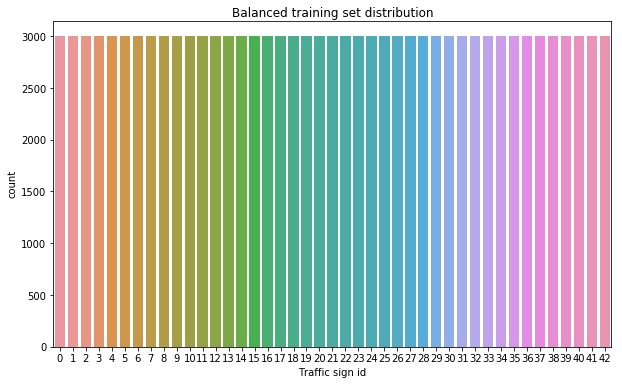

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(y_train_bal)
plt.title('Balanced training set distribution')
plt.xlabel('Traffic sign id');

#### Check if labels are still correct after balancing

In [10]:
def plot_rand(X_data, y_data, prepro_gray=False):
    rand_inds = np.random.randint(0,len(X_data),size=(1,6))

    num_rows = 2
    num_cols = 3

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15,6))
    fig.subplots_adjust(wspace=2)
    axs = axs.ravel()

    for i in range(num_rows*num_cols):
        if not prepro_gray:
            axs[i].imshow(X_data[rand_inds[0][i]])
        if prepro_gray:
            axs[i].imshow(X_data[rand_inds[0][i],:,:,0],cmap='gray')
        sign_id = y_data[rand_inds[0][i]]
        axs[i].title.set_text(map_ids[sign_id])

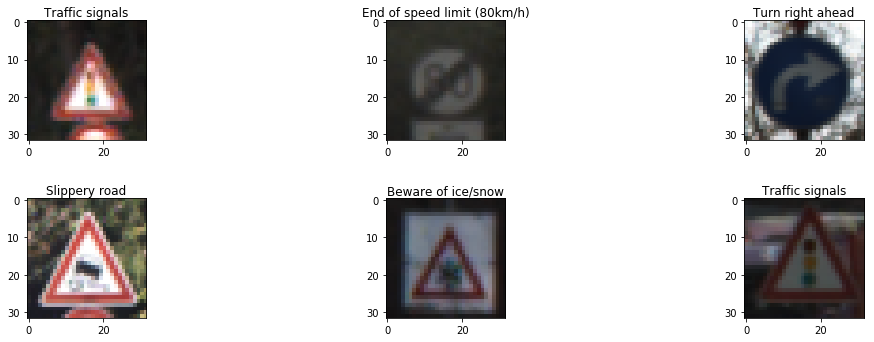

In [11]:
plot_rand(X_train_bal, y_train_bal)

#### Define transformation functions

All images of the training data set are manipulated slightly by performing the following affine transformations:
* translation ([-2,2] pixels)
* scaling (factor [0.9,1.1])
* rotation ([-15,15] degrees)

In [12]:
import cv2

def translate(image, pixels=2): # value taken from "lecun-paper"
    tx = np.random.randint(-pixels, pixels+1)
    ty = np.random.randint(-pixels, pixels+1)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    return cv2.warpAffine(image, M, (32, 32))

def scale(image, scale_val=.1): # value taken from "lecun-paper"
    # rotation functions used for scaling
    factor = 1 + (np.random.rand()-.5)*scale_val
    M = cv2.getRotationMatrix2D((16,16),0,factor)
    return cv2.warpAffine(image, M, (32,32))

def rotate(image, angle=15): # angle taken from "lecun-paper"
    angle = np.random.uniform(-angle, angle)
    M = cv2.getRotationMatrix2D((16, 16), angle, 1)
    return cv2.warpAffine(src=image, M=M, dsize=(32, 32))

# apply all transforms
def transform(image):
    image = translate(image)
    image = scale(image)
    image = rotate(image)
    return image

#### Transform fraction of all test images

In [13]:
from sklearn.utils import shuffle

X_train_aug = np.copy(X_train_bal)

trans_perc = 1 # define percentage (0..1) of training images to transform

# shuffle training images
X_train_aug, y_train_bal = shuffle(X_train_aug, y_train_bal)

for i in range(int(len(X_train_aug)*trans_perc)):
    # replace image by transformed one
    X_train_aug[i] = transform(X_train_aug[i])

#### Plot random images from augmented data set to check if label is correct

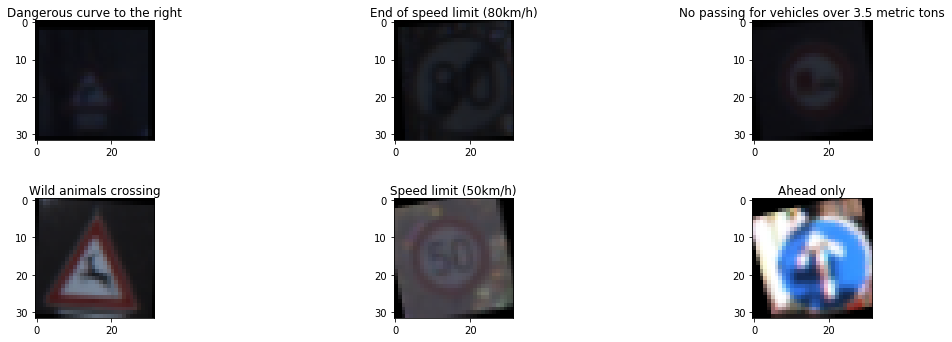

In [14]:
plot_rand(X_train_aug, y_train_bal)

----

## Step 2: Design and Test a Model Architecture


Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set

Normalizing the data is numerically beneficial since computations with very big and small numbers are avoided, which lead to relatively large errors in the loss function. Additionally, the optimizer easier finds a solution using normalized values.

In this project the 8-bit images are normalized by `(pixel-128)/128` so that all pixel values are in range [-1,1]. [Grayscaling](https://docs.opencv.org/3.1.0/de/d25/imgproc_color_conversions.html) led to a slightly decreased performance, which is why color images are fed into the network.

#### Function definitions

In [15]:
def x2gray(imgs):
    r_ch = imgs[:,:,:,0]
    g_ch = imgs[:,:,:,1]
    b_ch = imgs[:,:,:,2]
    imgs_gray = 0.299*r_ch + 0.587*g_ch + 0.114*b_ch
    return imgs_gray[:,:,:,np.newaxis]

def norm_img(imgs):
    return np.add(imgs, -128)/128

def preprocess(imgs, prepro_gray=True):
    imgs = norm_img(imgs)
    if prepro_gray:
        imgs = x2gray(imgs)
    return imgs

#### Function application

In [16]:
# Determines if preprocessing includes grayscaling
prepro_gray = True

X_train_prepro = preprocess(X_train_aug, prepro_gray)
X_valid_prepro = preprocess(X_valid, prepro_gray)
X_test_prepro = preprocess(X_test, prepro_gray)

In [17]:
print('Min and max values of preprocessed images:\n {:<12}{}\n {:<12}{}\n {:<12}{}\n'
      .format(('Training:'),
          (np.min(X_train_prepro), np.max(X_train_prepro)),
              ('Validation:'),
             (np.min(X_valid_prepro), np.max(X_valid_prepro)),
              ('Test:'),
             (np.min(X_test_prepro), np.max(X_test_prepro))))

Min and max values of preprocessed images:
 Training:   (-0.9999999999999999, 0.9921874999999999)
 Validation: (-0.9646328125, 0.9921874999999999)
 Test:       (-0.9716406249999999, 0.9921874999999999)



#### Plot some random preprocessed images

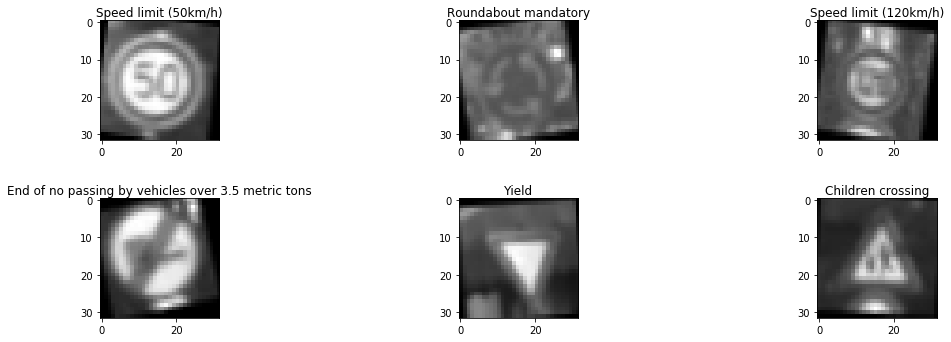

In [18]:
plot_rand(X_train_prepro, y_train_bal, prepro_gray)

## Model Architecture

With the LeNet-5 architecture as a starting point, a validation accuracy of 94% was reached. The accuracy was further increased by extending the network as follows:

* Increasing the number of filter layers
* Increasing the number of neurons in the hidden layers
* Adding an additional fully connected layer
* Using dropout in the fully connected layers

#### Final network architecture:

1. Layer: Convolutional
    * Convolution: input (32x32x1), output (28x28x16)
    * Activation ReLU
    * Pooling: input (28x28x16), output (14x14x16)
2. Layer: Convolutional
    * Convulution: input (14x14x16), output (10x10x25)
    * Activation: ReLU
    * Pooling: input (10x10x25), output (5x5x25)
    * Flattening: input (5x5x25), output (625)
3. Layer: Fully connected
    * Layer size: 400
    * Activation: ReLU
    * Dropout: 50%
4. Layer: Fully connected
    * Layer size: 256
    * Activation: ReLU
    * Dropout: 50%
5. Layer: Fully connected
    * Layer size: 128
    * Activation: ReLU
    * Dropout: 50%
6. Layer: Fully connected
    * Layer size: 43
    * Output: logits (43)
    
With this network architecture, a validation accuracy of 98% was reached. Feeding color images into the network led to slightly decreased accuracy values, which is why grayscale conversion is used.

In [19]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

if prepro_gray==True:
    img_depth = 1
else:
    img_depth = 3

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    ### convoluational layers
    
    # layer 1 - convolutional: input = 32x32x1, output = 28x28x16
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, img_depth, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    # pooling: input = 28x28x16, output = 14x14x16
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # layer 2 - convolutional: input = 14x14x16, output = 10x10x25
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 25), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(25))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    # pooling: input = 10x10x25, output = 5x5x25.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # flatten: input = 5x5x25, output = 625
    fc0 = flatten(conv2)
    
    ### fully connected layers
    
    # layer 3 - fully connected, input = 625, output = 400
    fc1_W = tf.Variable(tf.truncated_normal(shape=(625, 400), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(400))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, rate=drop_prob)

    # layer 4 - fully connected, input = 400, output = 256
    fc2_W = tf.Variable(tf.truncated_normal(shape=(400, 256), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(256))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, rate=drop_prob)

    # layer 5 - fully connected, input = 256, output = 128
    fc3_W = tf.Variable(tf.truncated_normal(shape=(256, 128), mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(128))
    fc3 = tf.matmul(fc2, fc3_W) + fc3_b
    fc3 = tf.nn.relu(fc3)
    fc3 = tf.nn.dropout(fc3, rate=drop_prob)

    # layer 6 - fully connected, input = 128, output = 43
    fc4_W  = tf.Variable(tf.truncated_normal(shape=(128, 43), mean = mu, stddev = sigma))
    fc4_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc3, fc4_W) + fc4_b
    
    return logits, conv1, conv2

In [20]:
x = tf.placeholder(tf.float32, (None, 32, 32, img_depth))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
drop_prob = tf.placeholder(tf.float32)

### Train, Validate and Test the Model

#### Model training
The model was trained using the augmented training data set. For optimization, the widely used ADAM method was applied, which was recommended in the lessons, too. The batch size seemed to have only a small influence on the validation accuracy; a value of 64 was chosen. The number of epochs is set to 100, but the training process is interupted when there is no increase in validation accuracy for 5 epochs. Another hyperparameter used was dropout in all fully connected layer. It was set to 50% (keep-rate) during training and to 100% for validation. The highest validation accuracy found was achieved with a training rate of 0.001. Since the network tends to overfit a little, L2 regularization was tested. Since this led to a significantly decreased accuracy, the method is not used here.

#### Solution approach
To find a solution, the initial LeNet-5 network was extended for reaching higher accuracy values. The final hyperparameter combination was found by trial-and-error, a systematic approch seemed too expensive with the given setup. Finally, a validation accuracy of 98.5% was reached.

Check GPU status

In [21]:
print(tf.test.is_gpu_available())
print(tf.test.gpu_device_name())
print(tf.test.is_built_with_cuda())

True
/device:GPU:0
True


### Training pipeline

In [22]:
EPOCHS = 100
BATCH_SIZE = 64
rate = 0.001
dropout_prob = 0.5

# input is passed to LeNet function to calculate logits
logits, conv1, conv2 = LeNet(x)
# compare logits to ground truth labels and calculate cross entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
# averages cross entropy from all training images
loss_operation = tf.reduce_mean(cross_entropy)
# initialize optimizer (Adam algorithm is similar to but more sofisticated than stochastic gradient descent)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
# backprob is used here
training_operation = optimizer.minimize(loss_operation)

W0801 14:23:49.893329 140238476289856 deprecation.py:323] From /home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/contrib/layers/python/layers/layers.py:1634: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0801 14:23:50.169111 140238476289856 deprecation.py:323] From <ipython-input-22-38e3f75724c3>:9: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Model Evaluation

In [23]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, drop_prob: 0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# Model Training

Training...


EPOCH   1: train_acc = 0.889 , valid_acc = 0.890 (max)
EPOCH   2: train_acc = 0.965 , valid_acc = 0.951 (max)
EPOCH   3: train_acc = 0.978 , valid_acc = 0.960 (max)
EPOCH   4: train_acc = 0.985 , valid_acc = 0.971 (max)
EPOCH   5: train_acc = 0.987 , valid_acc = 0.963 
EPOCH   6: train_acc = 0.990 , valid_acc = 0.977 (max)
EPOCH   7: train_acc = 0.987 , valid_acc = 0.961 
EPOCH   8: train_acc = 0.990 , valid_acc = 0.976 
EPOCH   9: train_acc = 0.991 , valid_acc = 0.976 
EPOCH  10: train_acc = 0.994 , valid_acc = 0.979 (max)
EPOCH  11: train_acc = 0.993 , valid_acc = 0.983 (max)
EPOCH  12: train_acc = 0.994 , valid_acc = 0.975 
EPOCH  13: train_acc = 0.995 , valid_acc = 0.980 
EPOCH  14: train_acc = 0.997 , valid_acc = 0.981 
EPOCH  15: train_acc = 0.996 , valid_acc = 0.979 
EPOCH  16: train_acc = 0.995 , valid_acc = 0.985 (max)
EPOCH  17: train_acc = 0.996 , valid_acc = 0.982 
EPOCH  18: train_acc = 0.995 , valid_acc = 0.981 
EPOCH  19: train_acc = 0.993 , valid_acc = 0.9

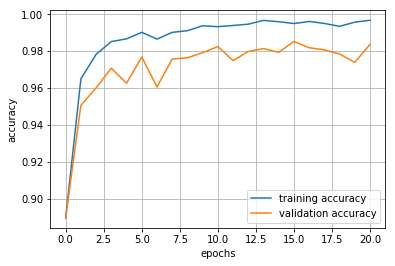

In [24]:
from tqdm import tqdm
import time
import pandas as pd

try:
    saver
except NameError:
    saver = tf.train.Saver()

max_acc = 0
max_acc_epoch = 0

# start time measurement
time_start = time.time()

acc_df = pd.DataFrame({'epoch': [], 'train acc': [], 'valid acc': []})

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_prepro)

    print("Training...")
    print()
    
    for i in range(EPOCHS):
        
        X_train_prepro, y_train_bal = shuffle(X_train_prepro, y_train_bal)
#         for offset in tqdm(range(0, num_examples, BATCH_SIZE)): # includes tqdm progess meter
        for offset in range(0, num_examples, BATCH_SIZE): #without tqdm progress meter     
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_prepro[offset:end], y_train_bal[offset:end]
            # training
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, drop_prob: dropout_prob})
                
        train_acc = evaluate(X_train_prepro, y_train_bal)
        valid_acc = evaluate(X_valid_prepro, y_valid)

        print("\nEPOCH {:>3}:".format(i+1), 
              "train_acc = {:.3f}".format(train_acc), ", "
              "valid_acc = {:.3f}".format(valid_acc),end=" ")

        acc_df = acc_df.append({'epoch': i, 
                       'training accuracy': train_acc, 'validation accuracy': valid_acc}, 
                      ignore_index=True)
        
        if valid_acc > max_acc:
            max_acc_epoch, max_acc = i, valid_acc
            saver.save(sess, './lenet-5_ext.ckpt')
            print('(max)',end="")
        elif i - max_acc_epoch >= 5:
            print('Stopping after 5 epochs without improvement.')
            break

    acc_df['training accuracy'].plot(legend=True)
    ax = acc_df['validation accuracy'].plot(grid=True,legend=True)
    ax.set_xlabel('epochs')
    ax.set_ylabel('accuracy');
    
# stop time measurement and print result
time_end = time.time()
print('Training time: ', np.round(time_end-time_start,2), 's')

#### Model to restore

In [25]:
model = './lenet-5_ext.ckpt'

The test set should be run only once after training and validation is done.

In [26]:
with tf.Session() as sess:
    saver.restore(sess, model)
    test_accuracy = evaluate(X_test_prepro, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

W0801 14:30:13.652929 140238476289856 deprecation.py:323] From /home/florian/.conda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Test Accuracy = 0.958


#### Confusion matrix
https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [27]:
with tf.Session() as sess:
    saver.restore(sess, model)
    y_test_pred = sess.run(tf.argmax(logits, 1), feed_dict={x: X_test_prepro, y: y_test, drop_prob: 0})

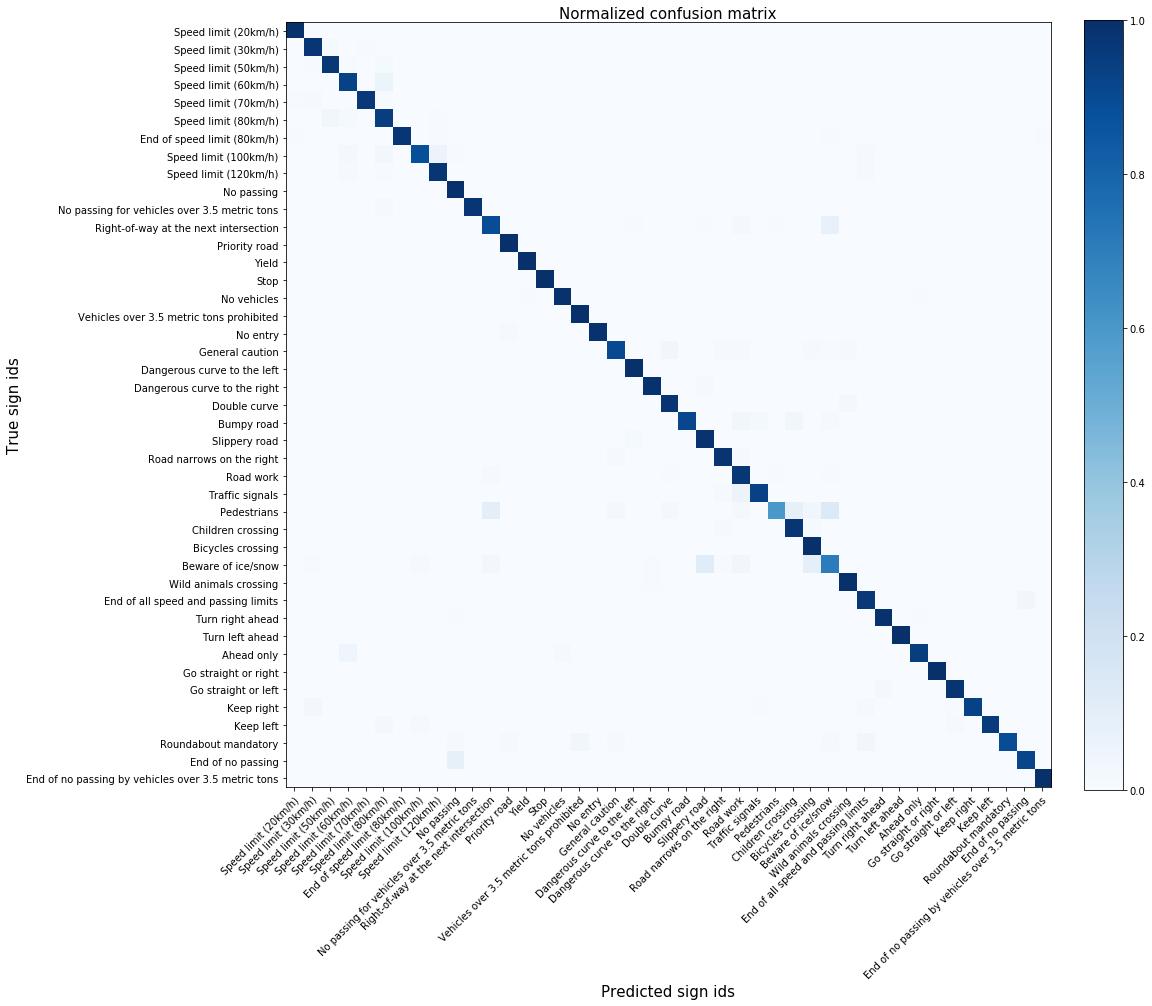

In [28]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)
# normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(cm, interpolation='nearest',cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
# show all ticks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=map_ids,
       yticklabels=map_ids)
ax.set_title('Normalized confusion matrix', fontsize=15)
ax.set_ylabel('True sign ids', fontsize=15)
ax.set_xlabel('Predicted sign ids', fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor');



#### Precision and recall

Precision:
tp/(tp+fp)

Recall:
tf/(tp+fn)

In [29]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_test_pred, average=None)#='weighted')
recall = recall_score(y_test, y_test_pred, average=None)#'weighted')
# print('precision: ', precision)
# print('recall: ', recall)

sign_dict = {'Sign names':map_ids, 'Precision': precision, 'Recall': recall}

sign_df = pd.DataFrame(sign_dict)
sign_df = sign_df[['Sign names', 'Precision', 'Recall']]
sign_df.style.background_gradient(cmap='RdYlGn',low=.5, high=1)


,Sign names,Precision,Recall
0,Speed limit (20km/h),0.895522,1
1,Speed limit (30km/h),0.953804,0.975
2,Speed limit (50km/h),0.955381,0.970667
3,Speed limit (60km/h),0.902597,0.926667
4,Speed limit (70km/h),0.99376,0.965152
5,Speed limit (80km/h),0.9,0.942857
6,End of speed limit (80km/h),1,0.973333
7,Speed limit (100km/h),0.980247,0.882222
8,Speed limit (120km/h),0.924211,0.975556
9,No passing,0.973631,1


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [30]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Read, preprocess and plot the new images

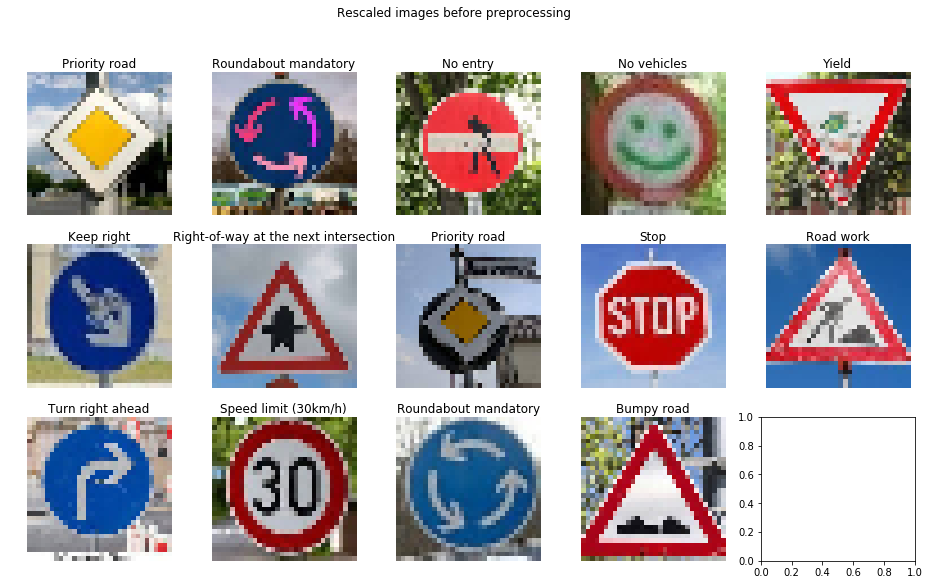

In [31]:
import os

X_new_test = []
path = './traffic_sign_images/'

img_names = sorted(os.listdir(path))
n_imgs = len(img_names)


X_test_new = np.zeros([len(img_names), 32, 32, 3], dtype=np.uint8)
y_test_new = np.array([12, 40, 17, 15, 13, 38, 11, 12, 14, 25, 33,  1, 40, 22])

fig, axs = plt.subplots(3,5,figsize=(16,9))
axs = axs.ravel()

plt.suptitle('Rescaled images before preprocessing')

for idx, img_name in enumerate(img_names):
    img = cv2.cvtColor(cv2.imread(path+img_name), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (32,32))
    X_test_new[idx] = img
    # plots:
    axs[idx].imshow(X_test_new[idx])
    axs[idx].set_title(map_ids[y_test_new[idx]])
    axs[idx].axis('off')

# preprocess all images
X_test_new_prepro = preprocess(X_test_new, prepro_gray)

### Predict the Sign Type for Each Image and analyze performance

In [32]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

In [33]:
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, model)
    y_pred_new = sess.run(tf.argmax(logits, 1), feed_dict={x: X_test_new_prepro, y: y_test_new, drop_prob: 0})
    print('Number:       ', np.arange(1,n_imgs+1))
    print('----------------------------------------------------------')
    print('Predicted id: ', y_pred_new)
    print('Ground truth: ', y_test_new)

Number:        [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
----------------------------------------------------------
Predicted id:  [12 40 17  9 13 38 11 12 14 25 33  1 40 22]
Ground truth:  [12 40 17 15 13 38 11 12 14 25 33  1 40 22]


### Analyze Performance

In [34]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

In [35]:
with tf.Session() as sess:
    saver.restore(sess, model)
    new_test_accuracy = evaluate(X_test_new_prepro, y_test_new)
    print("Test Accuracy (new images) = {:.3f}".format(new_test_accuracy))

Test Accuracy (new images) = 0.929


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [36]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

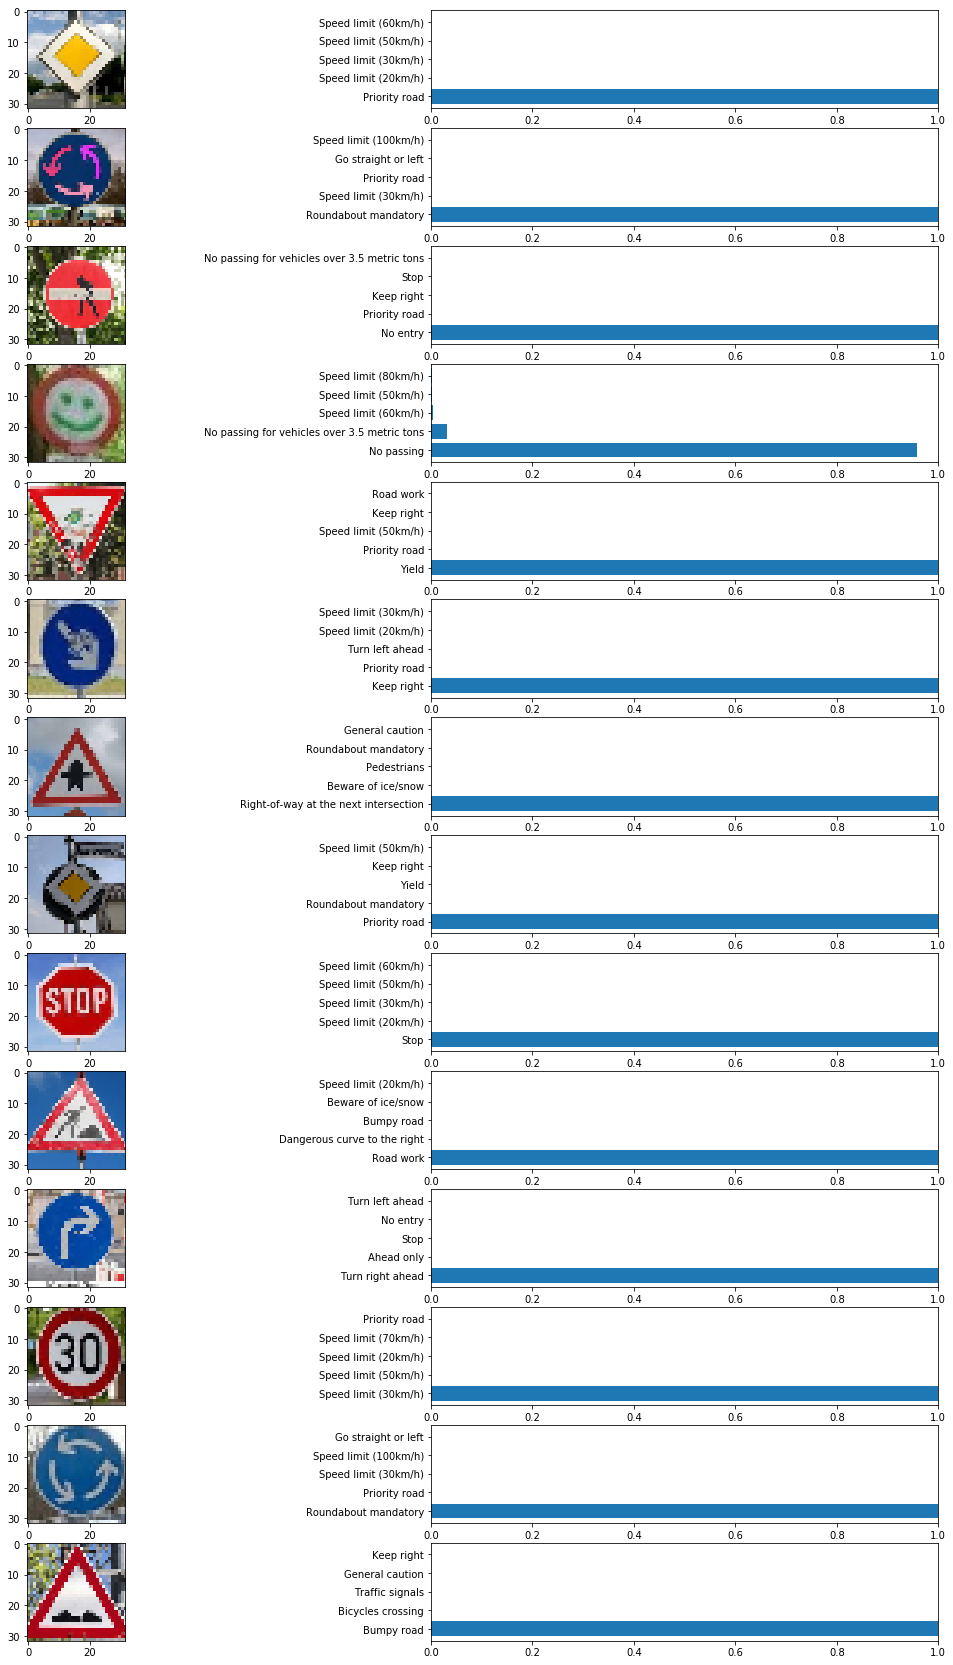

In [37]:
with tf.Session() as sess:
    saver.restore(sess, model)
    y_prob_new, y_pred_new = sess.run(tf.nn.top_k(tf.nn.softmax(logits), 5), 
                                      feed_dict={x: X_test_new_prepro, y: y_test_new, drop_prob: 0})

fig, axs = plt.subplots(n_imgs, 2, figsize=(20,30))
axs = np.ravel(axs)

for i in range(n_imgs):
    axs[2*i].imshow(X_test_new[i])
    axs[2*i+1].barh(np.arange(len(y_prob_new[0])), y_prob_new[i], align='center')
    pred_labels = [map_ids[j] for j in y_pred_new[i]]
    axs[2*i+1].set_xlim([0,1])
    axs[2*i+1].set_yticks(np.arange(0,len(pred_labels),1))
    axs[2*i+1].set_yticklabels(pred_labels)

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images



For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [38]:
# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# Note: that to get access to tf_activation, the session should be interactive which can be achieved with the following commands.
# sess = tf.InteractiveSession()
# sess.as_default()

# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and    max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =#         saver = tf.train.Saver()
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x: image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

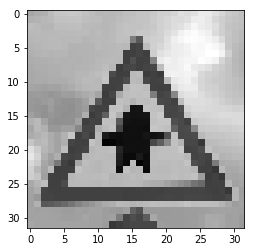

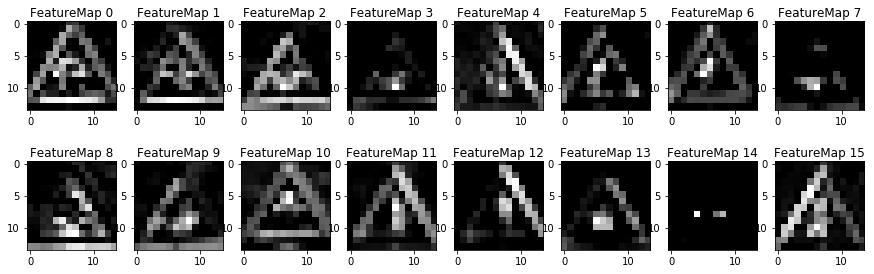

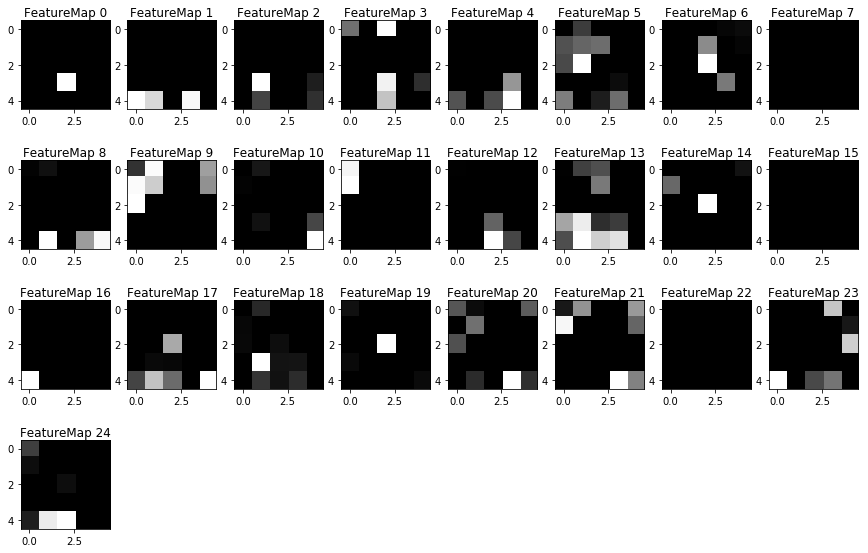

In [39]:
with tf.Session() as sess:    
    saver.restore(sess, model)
    
    img_idx = 6
    if prepro_gray:
        plt.imshow(X_test_new_prepro[img_idx,:,:,0], cmap='gray')
    else:
        plt.imshow(X_test_new_prepro[img_idx])
    plt.show()
    outputFeatureMap(X_test_new_prepro[img_idx].reshape(1,32,32,img_depth), conv1, plt_num=1)
    outputFeatureMap(X_test_new_prepro[img_idx].reshape(1,32,32,img_depth), conv2, plt_num=2)
    

(32, 32, 3)


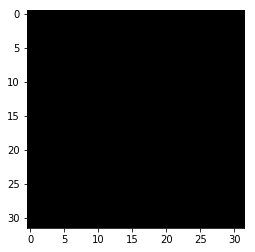

ValueError: cannot reshape array of size 3072 into shape (1,32,32,1)

In [40]:
with tf.Session() as sess:    
    saver.restore(sess, model)
    
    img_idx = 11
    blank_img = np.zeros([1,32,32,3], dtype=np.uint8)
    print(blank_img[0].shape)
    plt.imshow(blank_img[0,:,:,0], cmap='gray')
    plt.show()
    outputFeatureMap(blank_img.reshape(1,32,32,1), conv1, plt_num=1)
    outputFeatureMap(blank_img.reshape(1,32,32,1), conv2, plt_num=2)
    